In [109]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import distinct

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
Measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [11]:
Station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


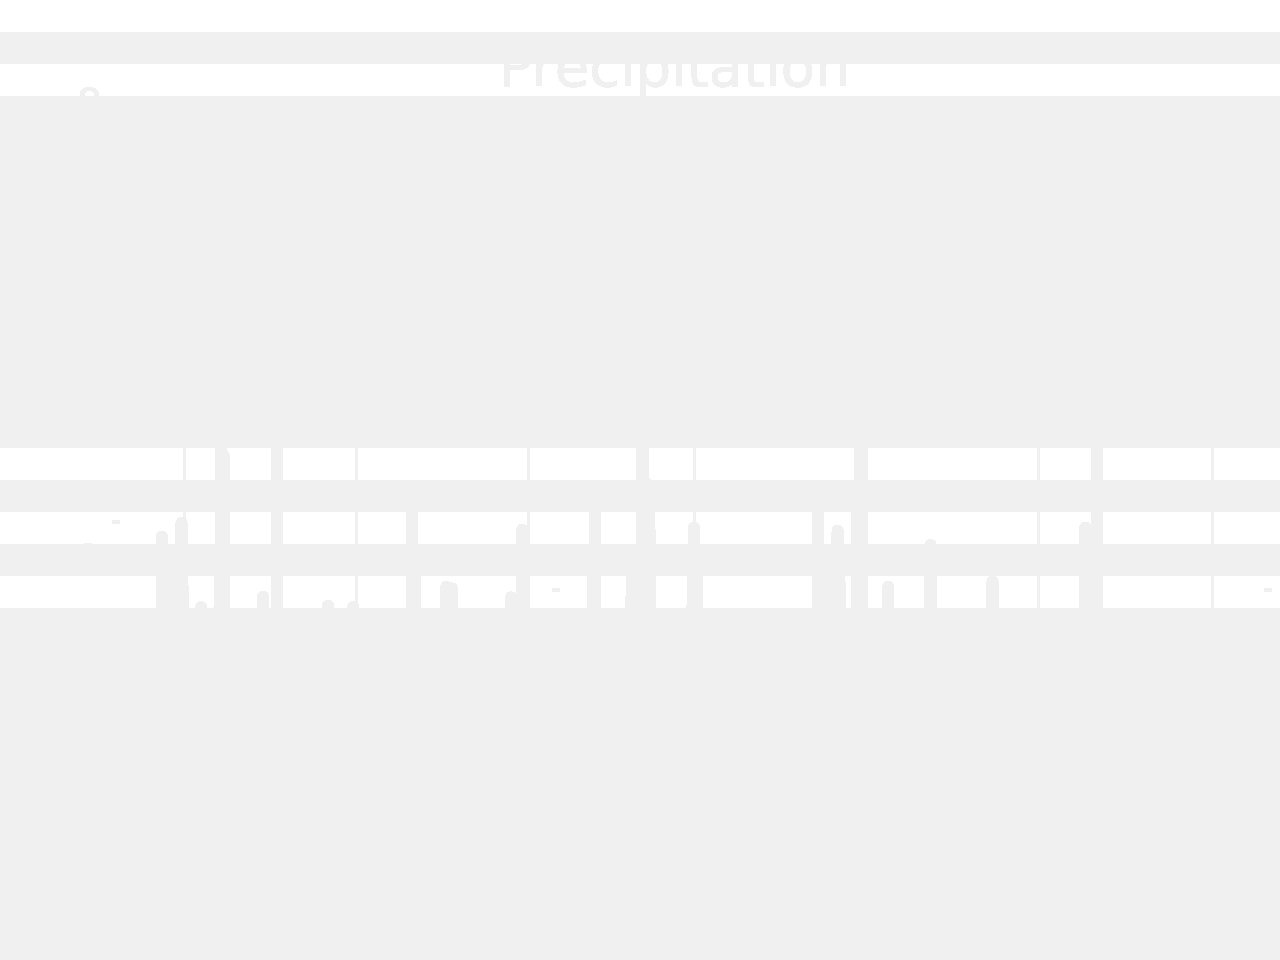

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

max_date = session.query(
    func.max(Measurement.date)
).first()
max_date = [r for r in max_date]
last_date = dt.datetime.strptime(max_date[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set

prev_year = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()
query_list = [r for r in query]

# Save the query results as a Pandas DataFrame and set the index to the date column

climate_df = pd.DataFrame(query_list,columns=['date', 'precipitation'])
climate_df['date'] =pd.to_datetime(climate_df.date)
climate_df.set_index('date', inplace=True)

# Sort the dataframe by date

climate_df = climate_df.sort_values(by='date',ascending=False)
# # Use Pandas Plotting with Matplotlib to plot the data
climate_df = climate_df.dropna()
climate_df.plot()
plt.xticks(rotation=45)
plt.ylim(0,8)
plt.title("Precipitation")
plt.legend(loc='upper right')
plt.tight_layout()
# Rotate the xticks for the dates

<IPython.core.display.Javascript object>


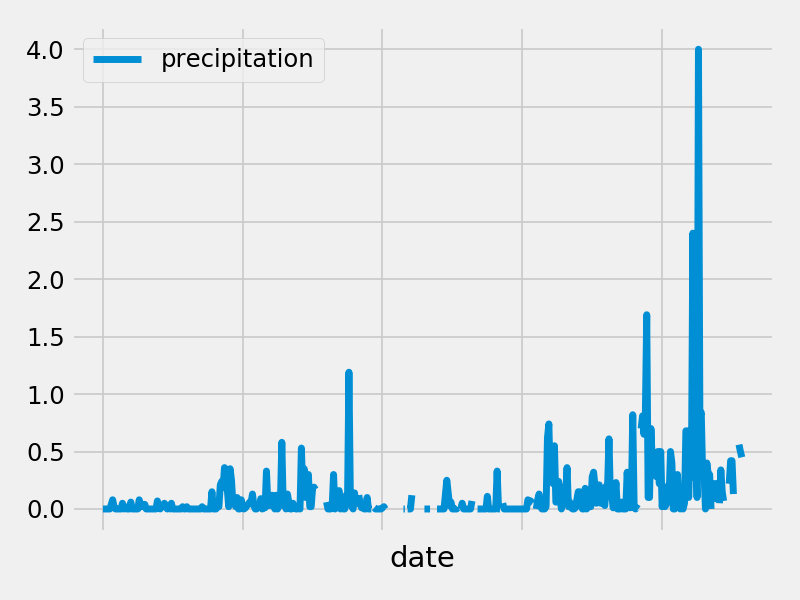

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date one year from the last date in data set

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

# Rotate the xticks for the dates


In [147]:
# Use Pandas to calcualte the summary statistics for the precipitation data

climate_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


,precipitation
count,412.000000
mean,0.117549
std,0.294210
min,0.000000
25%,0.000000
50%,0.020000
75%,0.120000
max,4.000000


In [148]:
# How many stations are available in this dataset?
station_count = session.query(func.count(Station.station)).all()
print(station_count)

[(9,)]


In [149]:
# What are the most active stations?
# List the stations and the counts in descending order.
q = [r for r in session.query(
    Measurement.station,
        func.count(Measurement.station)
        ).group_by(Measurement.station
            ).order_by(func.count(Measurement.station).desc()).all()]
q

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [150]:
# Most active station

most_active_station = q[0][0]
most_active_station

'USC00519281'

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


[(54.0, 85.0, 71.66378066378067)]

In [151]:
[r for r in session.query(
                func.min(Measurement.tobs),
                func.max(Measurement.tobs),
                func.avg(Measurement.tobs)).filter(
                Measurement.station == most_active_station)]


[(54.0, 85.0, 71.66378066378067)]

<IPython.core.display.Javascript object>


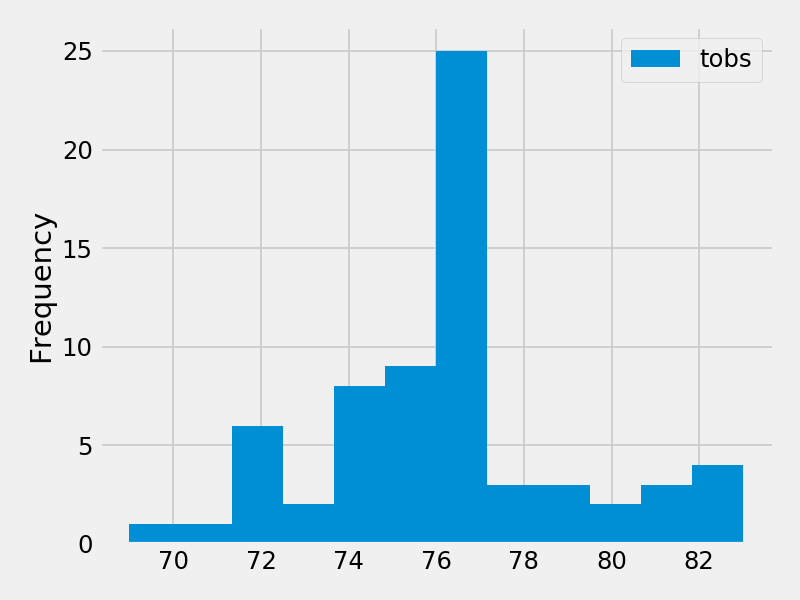

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


USC00519281


<IPython.core.display.Javascript object>


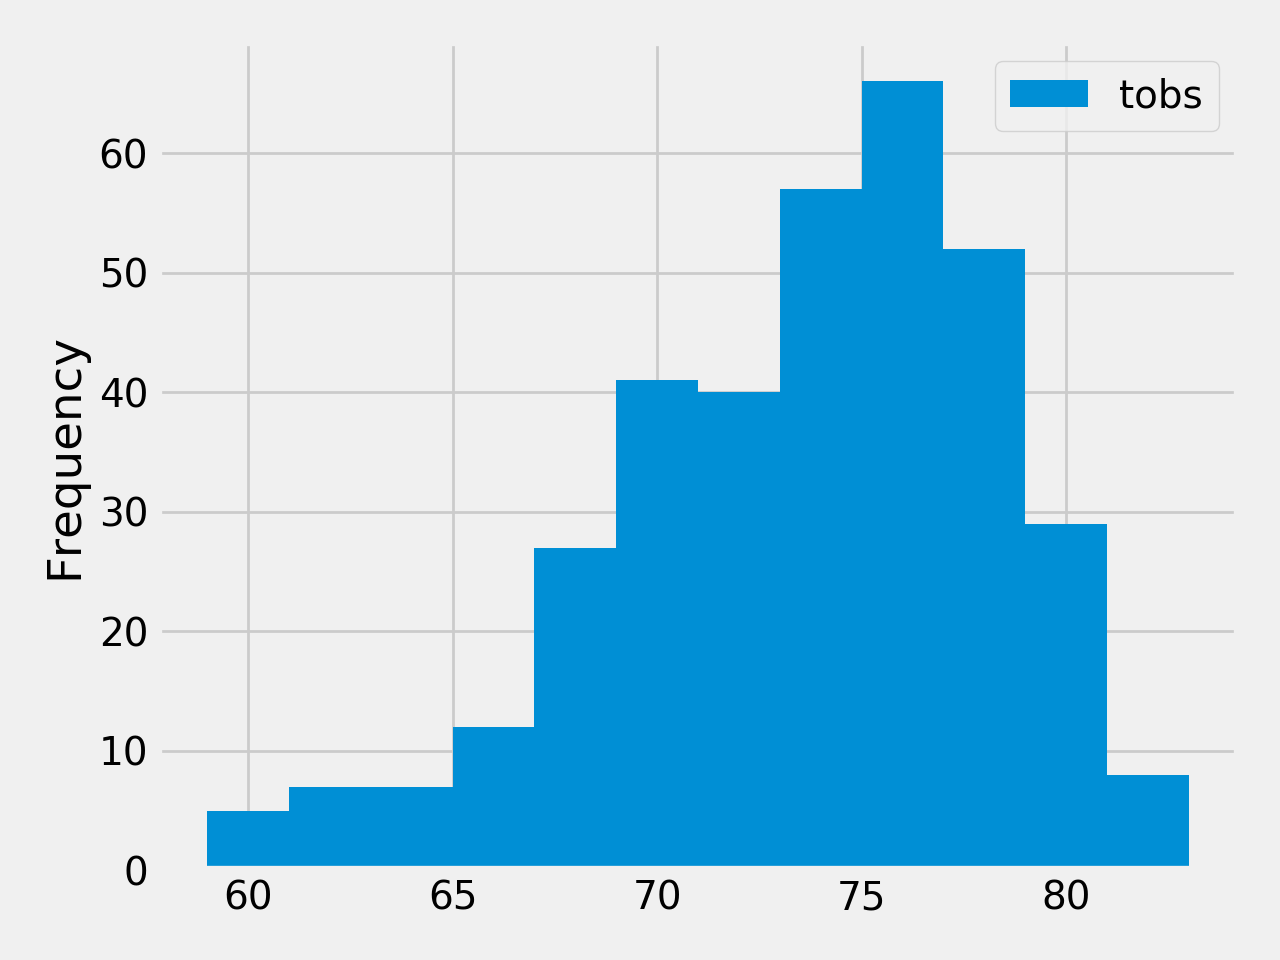

In [176]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

q = [r for r in session.query(
    Measurement.station,
        func.count(Measurement.tobs)
        ).group_by(Measurement.station
            ).order_by(func.count(Measurement.tobs).desc()).first()]
highest_tobs = q[0]
print(highest_tobs)

tobs_q = session.query(Measurement.tobs
                      ).filter(Measurement.date >= prev_year).filter(Measurement.station == highest_tobs).all()
tobs_df = pd.DataFrame(tobs_q)
tobs_df.head()
tobs_df.plot.hist(bins=12)

plt.legend(loc='best')
plt.tight_layout()

In [20]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [36]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = dt.date(2017,9,1)
end_date = dt.date(2017,9,9)
prev_year_start_date = start_date - dt.timedelta(days=365)
prev_year_end_date = end_date - dt.timedelta(days=365)
tmin, tavg, tmax = calc_temps(prev_year_start_date, prev_year_end_date)[0]
print(tmin, tavg, tmax)

73.0 77.96363636363637 84.0


<IPython.core.display.Javascript object>


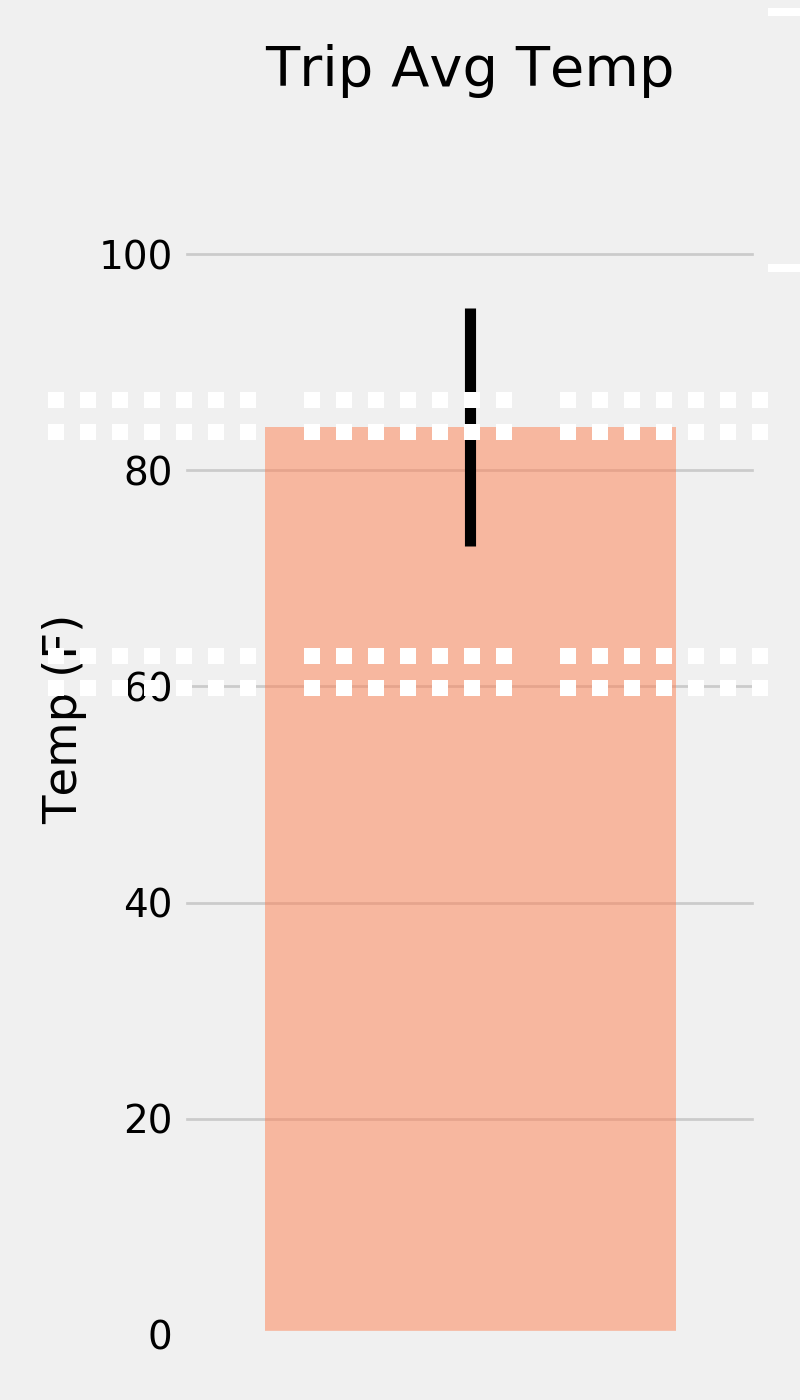

In [79]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

plt.figure(figsize=(4,7))
plt.bar(xpos, tmax, yerr=yerr, alpha=0.5, width=0.1, color='coral', align="center")
plt.xticks(np.arange(1, 1.0))
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.margins(0.2,0.2)
plt.tight_layout()

<IPython.core.display.Javascript object>


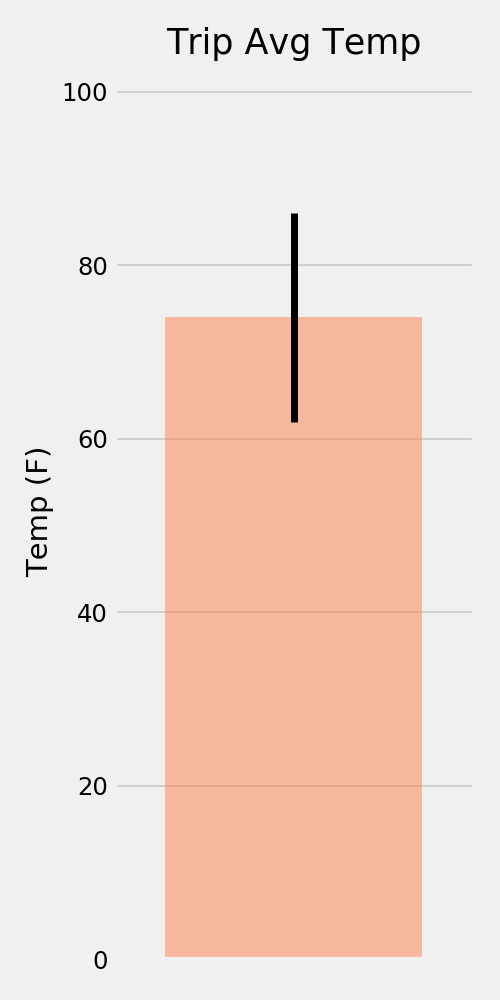

In [82]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

q = [r for r in session.query(
    Measurement.station,Station.name, 
    Station.latitude,
    Station.longitude, 
    Station.elevation,
        func.sum(Measurement.prcp)
        ).filter(Measurement.date >= prev_year_start_date
                ).filter(Measurement.date <= prev_year_end_date
                        ).group_by(Measurement.station
                                  ).order_by(func.sum(Measurement.prcp).desc()).all()]
q

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  40.59),
 ('USC00519523',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  10.979999999999999),
 ('USC00519281',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  7.3800000000000034),
 ('USC00514830',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  6.839999999999998),
 ('USC00513117',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  5.4899999999999975),
 ('USC00519397',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.9900000000000004),
 ('USC00517948',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  None)]

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [90]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [92]:
trip_dates = pd.date_range(start_date, end_date, freq='D')
print(trip_dates)
month_day = trip_dates.strftime("%m-%d")
print(month_day)
normals = []
for date in month_day:
    normals.append(*daily_normals(date))
    
normals

DatetimeIndex(['2017-09-01', '2017-09-02', '2017-09-03', '2017-09-04',
               '2017-09-05', '2017-09-06', '2017-09-07', '2017-09-08',
               '2017-09-09'],
              dtype='datetime64[ns]', freq='D')
Index(['09-01', '09-02', '09-03', '09-04', '09-05', '09-06', '09-07', '09-08',
       '09-09'],
      dtype='object')


[(69.0, 77.0, 82.0),
 (67.0, 76.66666666666667, 83.0),
 (69.0, 76.13725490196079, 83.0),
 (68.0, 76.27083333333333, 84.0),
 (66.0, 75.91489361702128, 84.0),
 (66.0, 74.91111111111111, 81.0),
 (64.0, 75.18, 82.0),
 (66.0, 76.22222222222223, 83.0),
 (68.0, 76.36538461538461, 84.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [101]:
daily_normals_df = pd.DataFrame()
daily_normals_df = pd.DataFrame(normals, 
                                     index=trip_dates, columns=[ 'tmin', 'tavg', 'tmax'])
daily_normals_df.index.name = 'date'
daily_normals_df

,tmin,tavg,tmax
date,,,
2017-09-01,69.0,77.000000,82.0
2017-09-02,67.0,76.666667,83.0
2017-09-03,69.0,76.137255,83.0
2017-09-04,68.0,76.270833,84.0
2017-09-05,66.0,75.914894,84.0
2017-09-06,66.0,74.911111,81.0
2017-09-07,64.0,75.180000,82.0
2017-09-08,66.0,76.222222,83.0
2017-09-09,68.0,76.365385,84.0


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


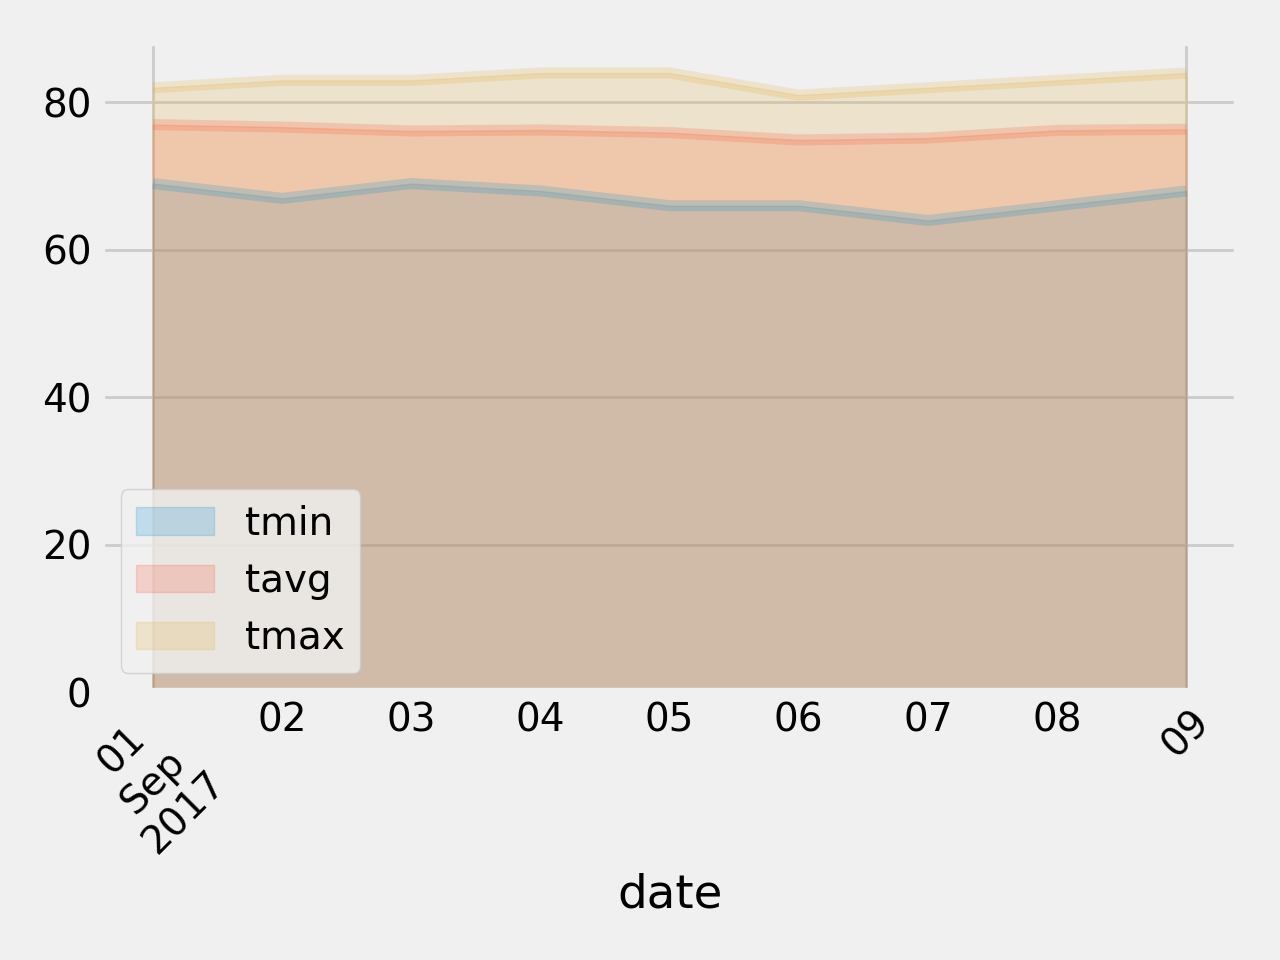

In [116]:
ax = daily_normals_df.plot.area(alpha=.2, stacked=False)
plt.xticks(rotation=45)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.tight_layout()


<IPython.core.display.Javascript object>


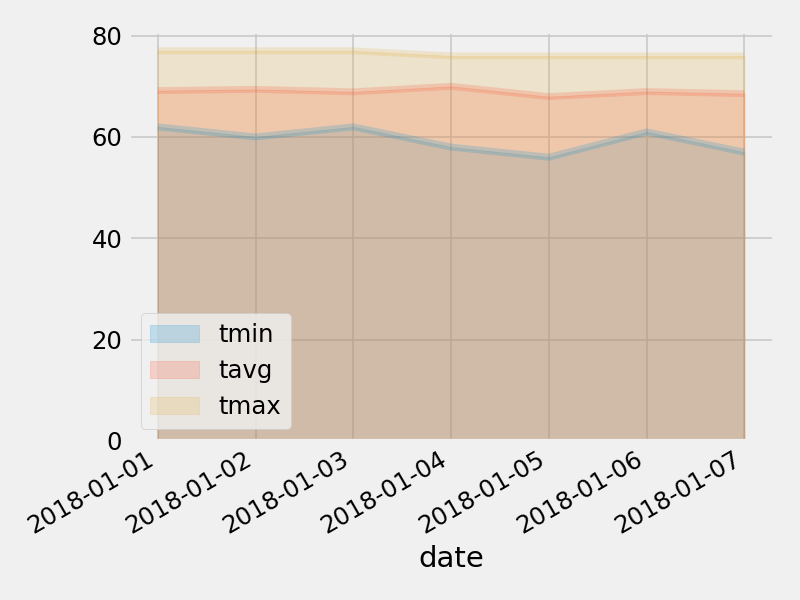

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
